<a href="https://colab.research.google.com/github/alexshtf/alexshtf.github.io/blob/polynomial_pruning/assets/calirofnia_housing_legendre_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from copy import deepcopy
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

from sklearn.base import OneToOneFeatureMixin, TransformerMixin, BaseEstimator, RegressorMixin
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted, validate_data

from tqdm.auto import tqdm

In [ ]:
plt.rcParams['figure.figsize'] = [4, 3]
plt.rcParams['figure.dpi'] = 160

In [ ]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=120)

# Load dataset



In [ ]:
train_df = pd.read_csv("sample_data/california_housing_train.csv")
test_df = pd.read_csv("sample_data/california_housing_test.csv")

In [ ]:
print(train_df.head(5).to_string(index=False))

 longitude  latitude  housing_median_age  total_rooms  total_bedrooms  population  households  median_income  median_house_value
   -114.31     34.19                15.0       5612.0          1283.0      1015.0       472.0         1.4936             66900.0
   -114.47     34.40                19.0       7650.0          1901.0      1129.0       463.0         1.8200             80100.0
   -114.56     33.69                17.0        720.0           174.0       333.0       117.0         1.6509             85700.0
   -114.57     33.64                14.0       1501.0           337.0       515.0       226.0         3.1917             73400.0
   -114.57     33.57                20.0       1454.0           326.0       624.0       262.0         1.9250             65500.0


In [ ]:
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [ ]:
X_train = train_df.drop("median_house_value", axis=1)
y_train = train_df["median_house_value"]

X_valid = valid_df.drop("median_house_value", axis=1)
y_valid = valid_df["median_house_value"]

X_test = test_df.drop("median_house_value", axis=1)
y_test = test_df["median_house_value"]

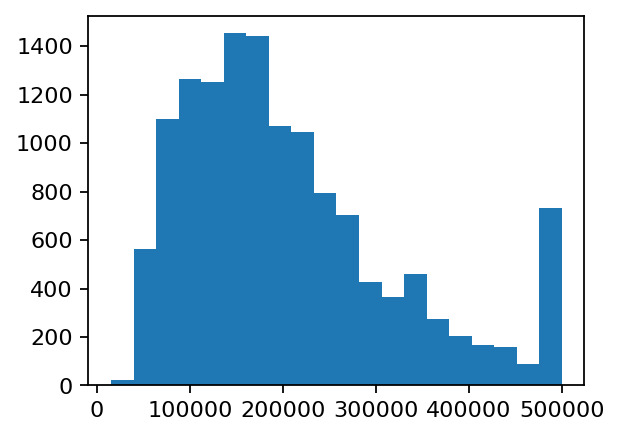

In [ ]:
plt.hist(y_train, bins=20)
plt.show()

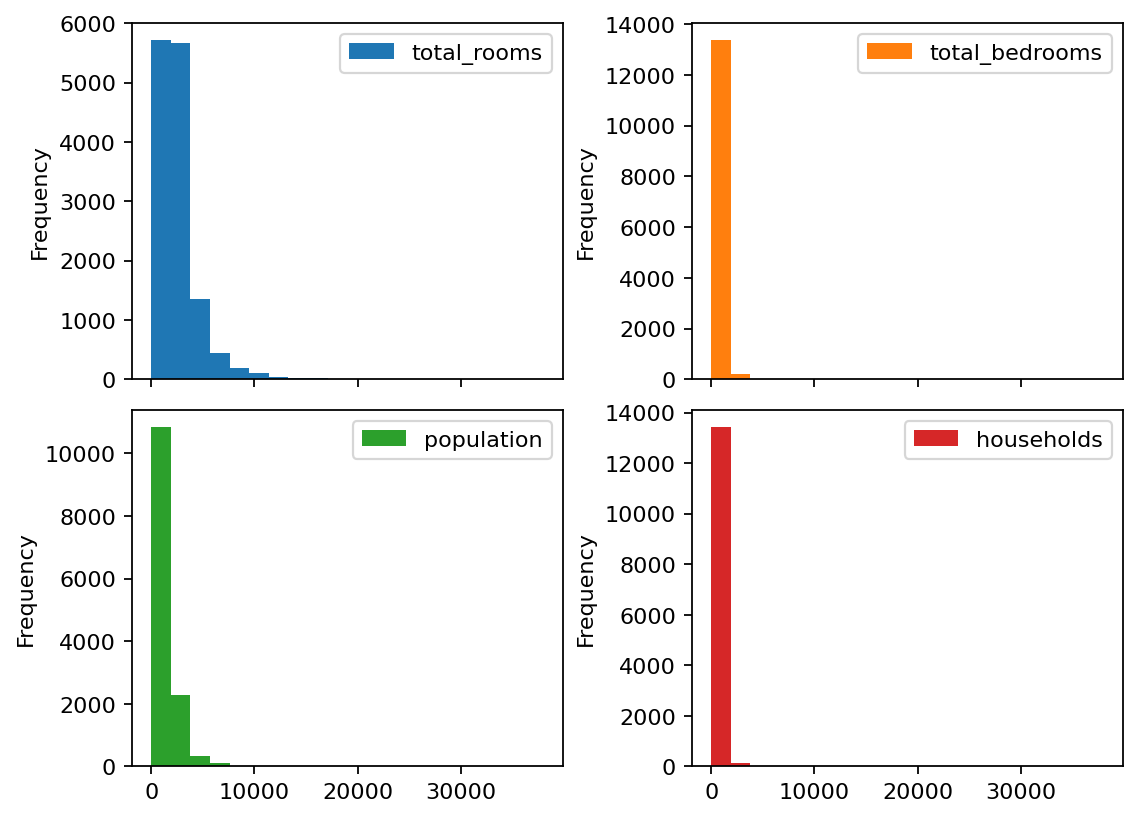

In [ ]:
# columns that we know have a very skewed distribution
skewed_columns = ['total_rooms', 'total_bedrooms', 'population', 'households']
X_train[skewed_columns].plot.hist(bins=20, subplots=True, layout=(2, 2), figsize=(7, 5))
plt.gcf().set_layout_engine('constrained')

In [ ]:
X_train.loc[:, skewed_columns] = X_train[skewed_columns].apply(np.log)
X_valid.loc[:, skewed_columns] = X_valid[skewed_columns].apply(np.log)
X_test.loc[:, skewed_columns] = X_test[skewed_columns].apply(np.log)

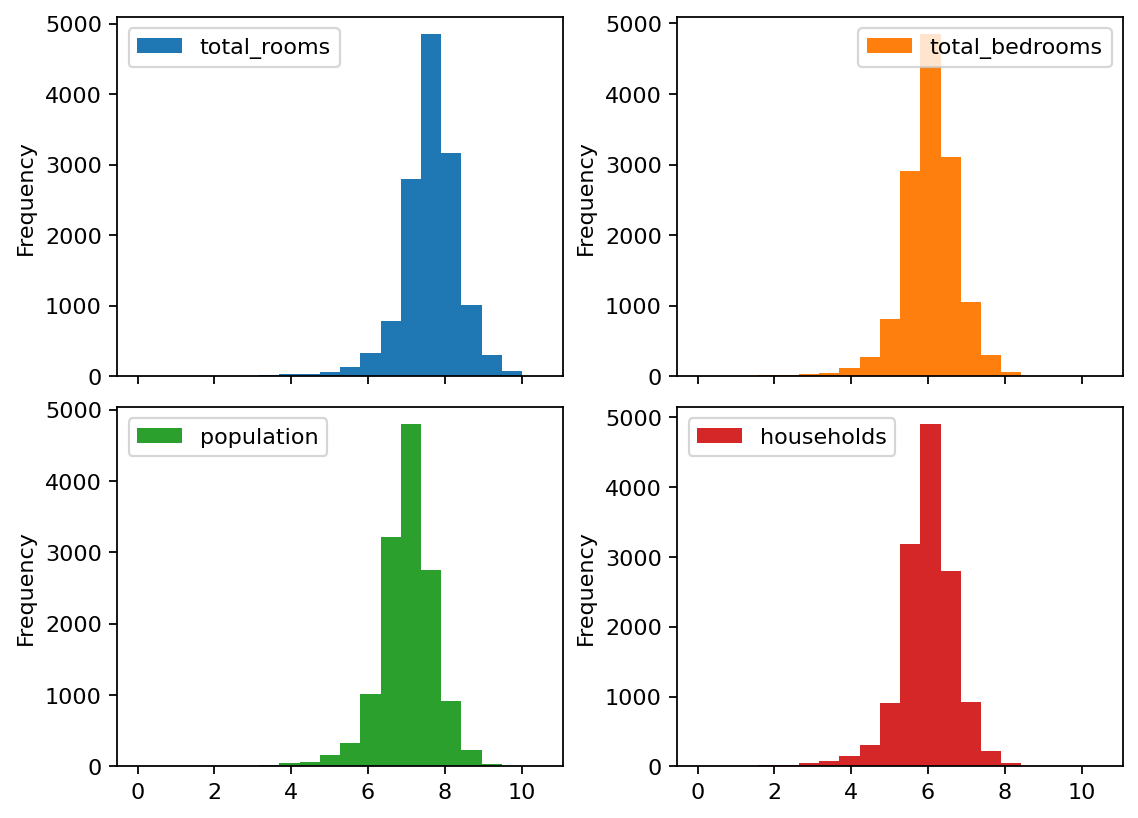

In [ ]:
X_train[skewed_columns].plot.hist(bins=20, subplots=True, layout=(2, 2), figsize=(7, 5))
plt.gcf().set_layout_engine('constrained')

In [ ]:
# insignificant_columns = ['housing_median_age', 'latitude', 'longitude']
# X_train = X_train.drop(insignificant_columns, axis=1)
# X_test = X_test.drop(insignificant_columns, axis=1)

# Transformer using Legendre basis

In [ ]:
X = np.array([
    [0, 0.2],
    [0.4, 0.6],
    [0.8, 1]
])
print(np.polynomial.legendre.legvander(X, 4))

[[[ 1.     0.    -0.5   -0.     0.375]
  [ 1.     0.2   -0.44  -0.28   0.232]]

 [[ 1.     0.4   -0.26  -0.44  -0.113]
  [ 1.     0.6    0.04  -0.36  -0.408]]

 [[ 1.     0.8    0.46   0.08  -0.233]
  [ 1.     1.     1.     1.     1.   ]]]


In [ ]:
print(np.polynomial.legendre.legvander(X, 4).reshape(3, -1))

[[ 1.     0.    -0.5   -0.     0.375  1.     0.2   -0.44  -0.28   0.232]
 [ 1.     0.4   -0.26  -0.44  -0.113  1.     0.6    0.04  -0.36  -0.408]
 [ 1.     0.8    0.46   0.08  -0.233  1.     1.     1.     1.     1.   ]]


In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator

class LegendreScalarPolynomialFeatures(TransformerMixin, BaseEstimator):
    def __init__(self, degree=2, include_bias=False):
        self.degree = degree
        self.include_bias = include_bias

    def fit(self, X, y=None):
        # There is nothing to learn
		# Legendre polynomials do not depend on the training data.
        return self

    def __sklearn_is_fitted__(self):
        # See above - it's always "fitted" by definition
        return True

    def transform(self, X, y=None):
        # Make sure X is of the right type and shape
        X = check_array(X, accept_sparse=False, ensure_all_finite=True)

        # create a Vandermonde matrix for each feature, and create a 3D array
        # of shape
        vander = np.polynomial.legendre.legvander(X, self.degree)
        if not self.include_bias:
            vander = vander[..., 1:]

        # reshape to concatenate the Vandermonde matrices horizontally
        n_rows = X.shape[0]
        return vander.reshape(n_rows, -1)

In [ ]:
print(LegendreScalarPolynomialFeatures(degree=4).transform(X))

[[ 0.    -0.5   -0.     0.375  0.2   -0.44  -0.28   0.232]
 [ 0.4   -0.26  -0.44  -0.113  0.6    0.04  -0.36  -0.408]
 [ 0.8    0.46   0.08  -0.233  1.     1.     1.     1.   ]]


# Run experiments with various degrees

In [ ]:
pipeline = Pipeline([
        ('minmaxscaler', MinMaxScaler(feature_range=(-1, 1), clip=True)),
        ('polyfeats', LegendreScalarPolynomialFeatures(degree=8)),
        ('model', LinearRegression()),
    ])

In [ ]:
pipeline.fit(X_train, y_train)
test_error = root_mean_squared_error(y_test, pipeline.predict(X_test))
print(f'Test error = {test_error:.4f}')

Test error = 63475.8142


In [ ]:
degrees = list(range(1, 10)) + np.geomspace(10, 40000, 12).astype(np.int32).tolist()

In [ ]:
train_rmses = []
test_rmses = []

# sample training set
n_samples = 5000
X_train_samples = X_train.iloc[:n_samples, :]
y_train_samples = y_train.iloc[:n_samples]

# fit various degrees
for degree in degrees:
    pipeline = Pipeline([
        ('minmaxscaler', MinMaxScaler(feature_range=(-1, 1), clip=True)),
        ('polyfeats', LegendreScalarPolynomialFeatures(degree=degree)),
        ('model', LinearRegression())
    ])
    pipeline.fit(X_train_samples, y_train_samples)
    y_train_pred  = pipeline.predict(X_train_samples)
    y_test_pred = pipeline.predict(X_test)

    train_rmses.append(root_mean_squared_error(y_train_samples, y_train_pred))
    test_rmses.append(root_mean_squared_error(y_test, y_test_pred))
    print(f"Degree: {degree}, "
          f"Test RMSE: {test_rmses[-1]:.2f}, "
          f"Train RMSE {train_rmses[-1]:.2f}")

Degree: 1, Test RMSE: 68326.20, Train RMSE 66776.99
Degree: 2, Test RMSE: 67522.42, Train RMSE 65720.98
Degree: 3, Test RMSE: 65784.84, Train RMSE 64030.37
Degree: 4, Test RMSE: 65227.71, Train RMSE 63353.57
Degree: 5, Test RMSE: 64907.57, Train RMSE 62297.19
Degree: 6, Test RMSE: 65134.09, Train RMSE 62006.36
Degree: 7, Test RMSE: 64675.77, Train RMSE 61721.51
Degree: 8, Test RMSE: 64534.99, Train RMSE 61459.37
Degree: 9, Test RMSE: 64962.61, Train RMSE 61285.31
Degree: 10, Test RMSE: 64433.99, Train RMSE 60810.69
Degree: 21, Test RMSE: 1701699.31, Train RMSE 57939.34
Degree: 45, Test RMSE: 2786592773542.82, Train RMSE 55145.90
Degree: 96, Test RMSE: 24926913710269.14, Train RMSE 50786.59
Degree: 204, Test RMSE: 6879185912413.60, Train RMSE 47511.24
Degree: 433, Test RMSE: 5893934722602.69, Train RMSE 41896.23
Degree: 922, Test RMSE: 1642004977035.12, Train RMSE 32491.25
Degree: 1959, Test RMSE: 295197737240.98, Train RMSE 14681.05
Degree: 4165, Test RMSE: 116144.54, Train RMSE 0.00
D

In [ ]:
print(np.corrcoef(X_train["total_rooms"], X_train["total_bedrooms"]))

[[1.         0.94465316]
 [0.94465316 1.        ]]


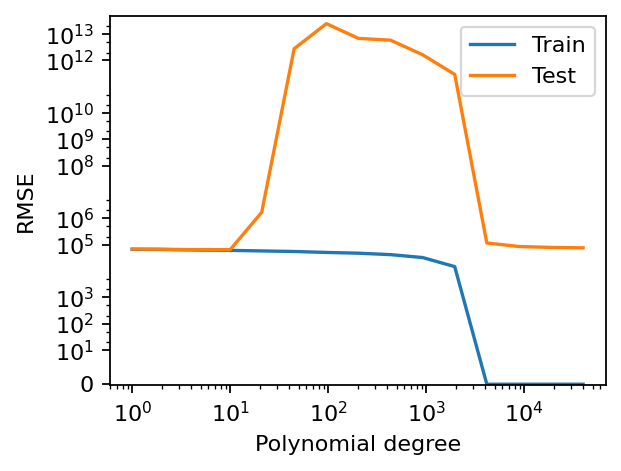

In [ ]:
fig, ax = plt.subplots()
ax.plot(degrees, train_rmses, label="Train")
ax.plot(degrees, test_rmses, label="Test")
ax.set_ylim([-0.1, 2 * np.max(test_rmses)])
ax.set_ylabel("RMSE")
ax.set_xscale('log')
ax.set_xlabel("Polynomial degree")
ax.set_yscale('asinh')
ax.legend()

fig.show()

# Pruning

In [ ]:
lin_reg = pipeline.named_steps['model']
print(lin_reg.coef_.shape)

(320000,)


In [ ]:
def get_feature_coefs(pipeline):
    num_features = pipeline.named_steps['minmaxscaler'].n_features_in_
    lin_reg = pipeline.named_steps['model']
    feature_coefs = lin_reg.coef_.reshape(num_features, -1)
    return feature_coefs


def plot_spectra(pipeline):
    feature_coefs = get_feature_coefs(pipeline)

    # define subplots for each feature
    n_cols = 3
    n_rows = math.ceil(feature_coefs.shape[0] / n_cols)
    width, height = plt.rcParams['figure.figsize']
    fig, axs = plt.subplots(
        n_rows, n_cols, figsize=[n_cols * width, n_rows * height],
        sharex=True,
        layout='constrained')

    # plot coefficients
    for i, (coef_vec, ax) in enumerate(zip(feature_coefs, axs.ravel())):
        ax.plot(coef_vec)
        ax.set_title(f'{X_train.columns[i]}')

    fig.show()

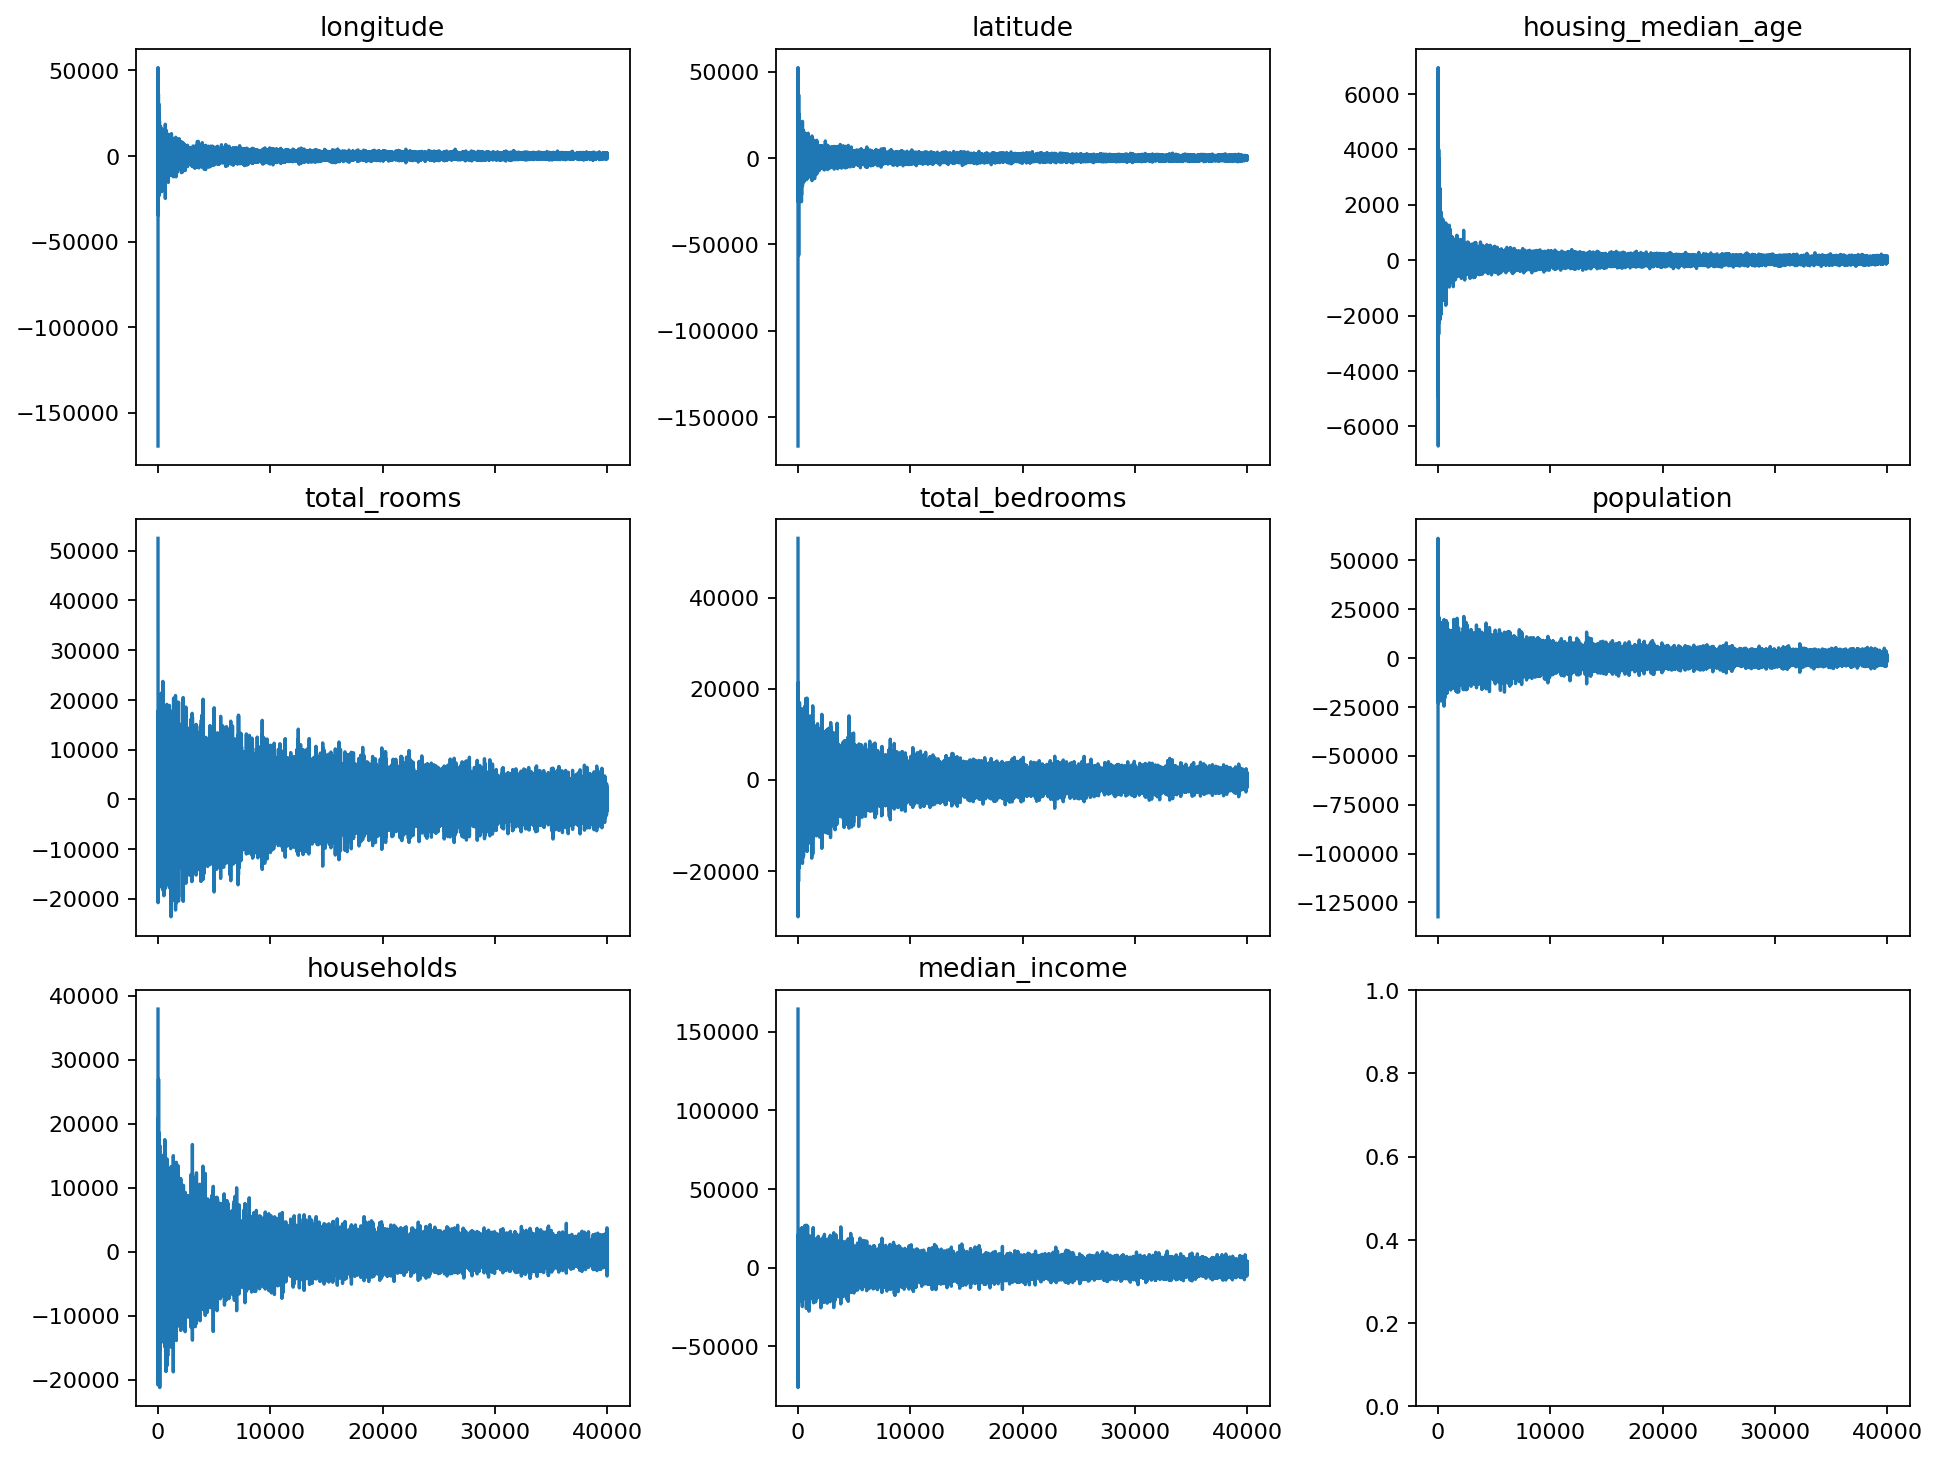

In [ ]:
plot_spectra(pipeline)

In [ ]:
def plot_feature_curves(
        pipeline, pruned_degrees=[1, 2, 3, 5, 10, 20, 2000], plot_resolution=5000
):
    # extract coefficients of each feature from the model
    feature_coefs = get_feature_coefs(pipeline)
    num_features = feature_coefs.shape[0]

    # define grid of plots for features x degrees
    width, height = plt.rcParams['figure.figsize']
    fig, axs = plt.subplots(
        feature_coefs.shape[0], len(pruned_degrees),
        layout='constrained', sharex=True, sharey='row',
        figsize=(width * len(pruned_degrees) / 3, height * num_features / 3))


    # compute Legendre Vandermonde matrix of maximum degree, to be pruned
    x_plot = np.linspace(0, 1, plot_resolution)
    full_vander = np.polynomial.legendre.legvander(x_plot, max(pruned_degrees))


    # do the plotting for each feature and degree
    for feat in range(num_features):
        for i, degree in enumerate(pruned_degrees):
            # prune coefficients of current feature at current degree
            pruned_coefs = feature_coefs[feat, :1 + degree]

            # prune Vandermonde matrix up to current degree
            pruned_vander = full_vander[:, :1 + degree]

            # plot the current degree polynomial
            y_plot = pruned_vander @ pruned_coefs
            axs[feat, i].plot(x_plot, y_plot)

            # put axis titles
            if feat == 0:
                axs[feat, i].set_title(f"deg={degree}")
            if i == 0:
                feature_name = X_train.columns[feat].replace("_", "\n")
                axs[feat, i].set_ylabel(feature_name)

    fig.align_ylabels(axs[:, 0])
    fig.show()

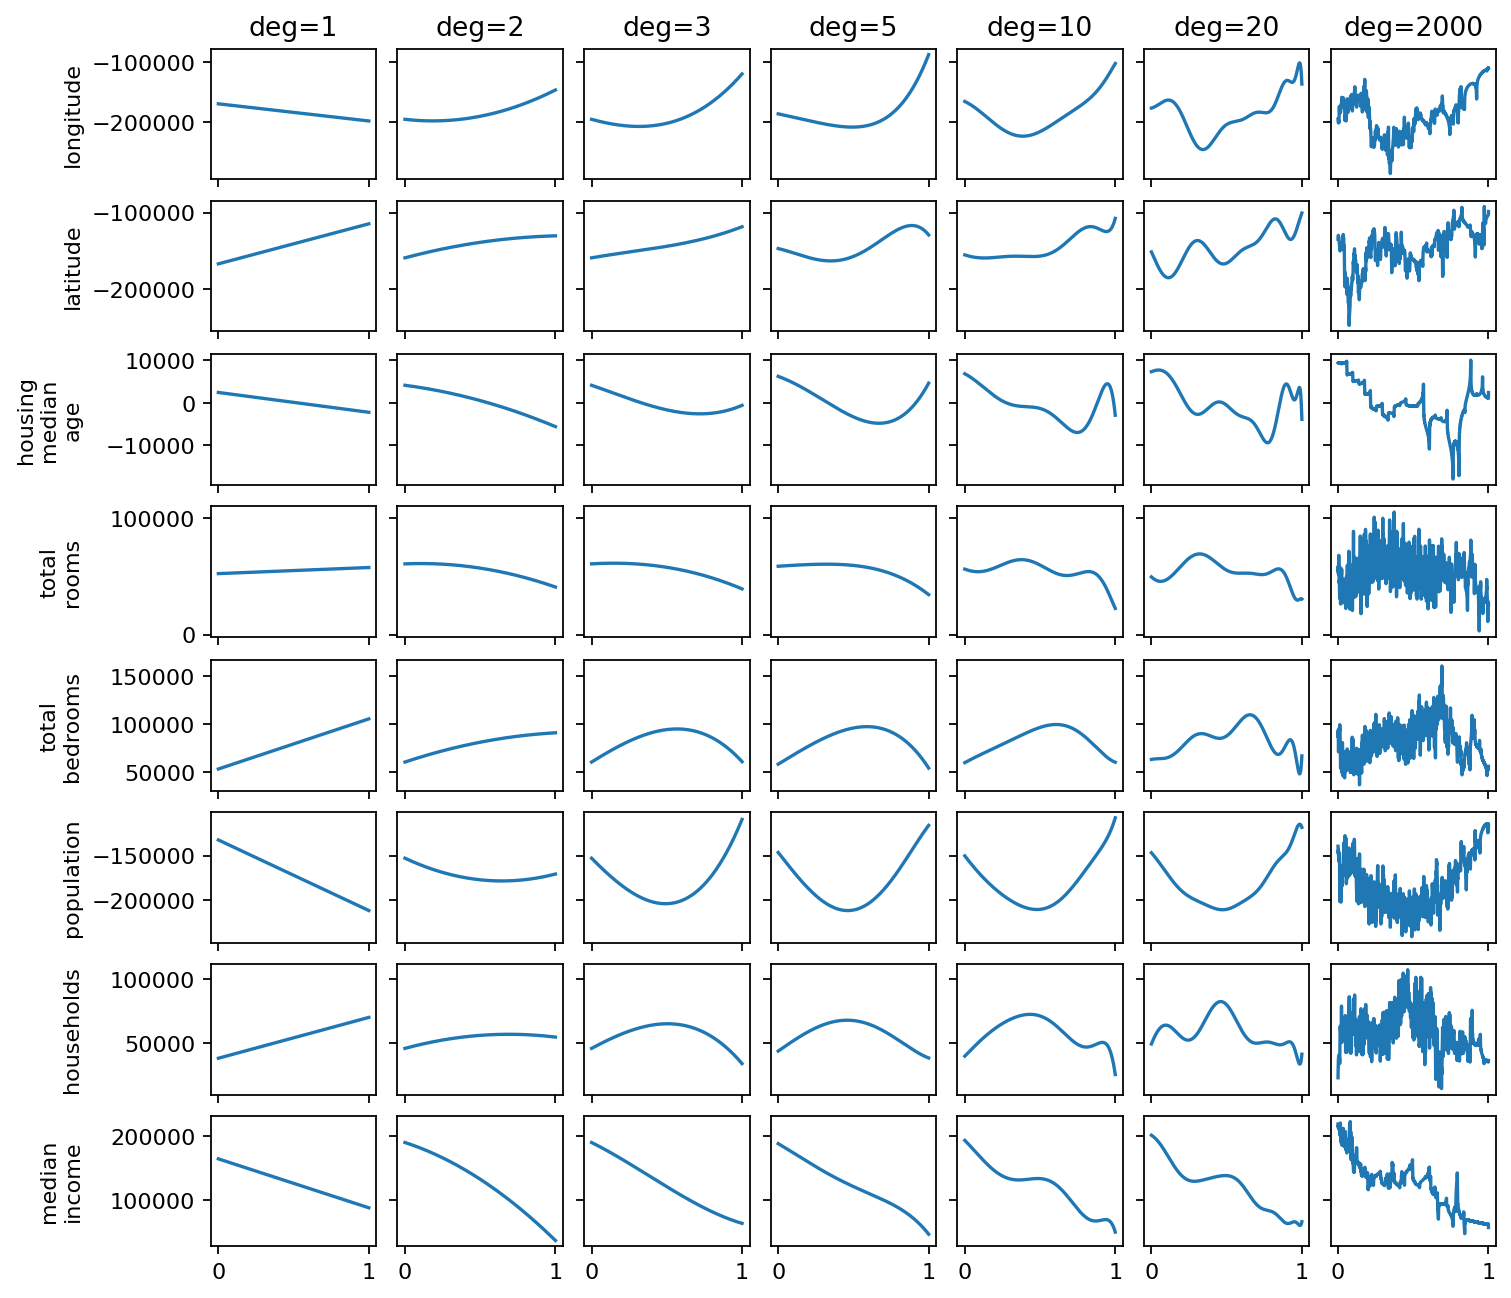

In [ ]:
plot_feature_curves(pipeline)

In [ ]:
def prune_pipeline(pipeline, pruned_deg):
    pruned = deepcopy(pipeline)
    num_features = pruned.named_steps['minmaxscaler'].min_.shape[0]
    orig_degree = pruned.named_steps['polyfeats'].degree
    pruned.named_steps['polyfeats'].degree = pruned_deg

    lin_reg = pruned.named_steps['model']
    orig_coef = lin_reg.coef_.reshape(num_features, orig_degree)
    pruned_coef = orig_coef[:, :pruned_deg].ravel()
    lin_reg.coef_ = pruned_coef
    lin_reg.n_features_in_ = pruned_coef.shape[0]

    return pruned

In [ ]:
prune_degrees = np.concatenate([
    np.arange(1, 100),
    np.geomspace(100, 5000, 50).astype(np.int32)
])
pruned_errors = np.zeros(len(prune_degrees))

for i, degree in enumerate(tqdm(prune_degrees)):
    pruned = prune_pipeline(pipeline, degree)
    y_valid_pred = pruned.predict(X_valid)
    pruned_errors[i] = root_mean_squared_error(y_valid, y_valid_pred)

  0%|          | 0/149 [00:00<?, ?it/s]

In [ ]:
best_degree = prune_degrees[np.argmin(pruned_errors)]
pruned = prune_pipeline(pipeline, best_degree)
pruned_test_error = root_mean_squared_error(y_test, pruned.predict(X_test))
print(f'Best degree = {best_degree}, test error = {pruned_test_error}')

Best degree = 100, test error = 60014.842969972255


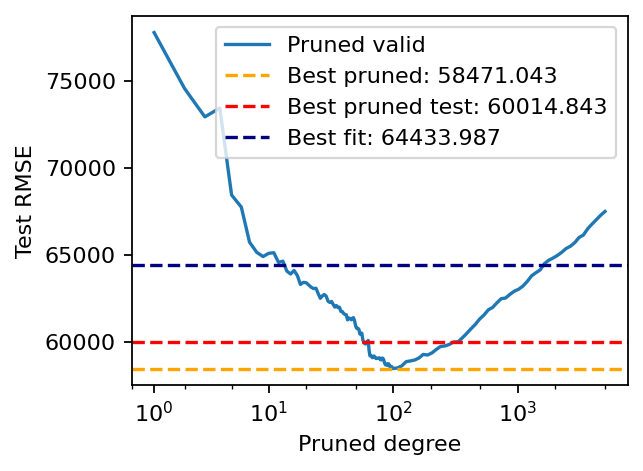

In [ ]:
plt.plot(prune_degrees, pruned_errors, label='Pruned valid')
plt.xlabel("Pruned degree")
plt.ylabel("Test RMSE")
plt.xscale('asinh')
plt.axhline(np.min(pruned_errors), linestyle='--',
            label=f'Best pruned: {np.min(pruned_errors):.3f}', color='orange')
plt.axhline(pruned_test_error, linestyle='--',
            label=f'Best pruned test: {pruned_test_error:.3f}', color='red')
plt.axhline(np.min(test_rmses), linestyle='--',
            label=f'Best fit: {np.min(test_rmses):.3f}', color='navy')
plt.legend()
plt.show()

# Greedy pruning

In [ ]:
def prune_feature(pipeline, feature, pruned_deg):
    pruned = deepcopy(pipeline)
    num_features = pruned.named_steps['minmaxscaler'].n_features_in_
    full_deg = pruned.named_steps['polyfeats'].degree

    regressor = pruned.named_steps['model']
    coef = regressor.coef_.reshape(num_features, full_deg)
    coef[feature, (1 + pruned_deg):] = 0
    regressor.coef_ = coef.ravel()

    return pruned

In [ ]:
pruned_pipeline = prune_pipeline(pipeline, 200)
degrees_to_try = range(0, 200)

for feature in range(X_train.shape[1]):
    best_deg = 0
    best_error = np.inf
    for deg in degrees_to_try:
        candidate = prune_feature(pruned_pipeline, feature, deg)
        pred = candidate.predict(X_valid)
        error = root_mean_squared_error(y_valid, pred)
        if error <= best_error:
            best_error = error
            best_deg = deg

    print(f"Best degree for feature {X_train.columns[feature]}: {best_deg}, validation error: {best_error}")
    pruned_pipeline = prune_feature(pruned_pipeline, feature, best_deg)

Best degree for feature longitude: 188, validation error: 59310.36603502216
Best degree for feature latitude: 198, validation error: 59302.68099683055
Best degree for feature housing_median_age: 16, validation error: 59072.43414192942
Best degree for feature total_rooms: 23, validation error: 58793.32412447594
Best degree for feature total_bedrooms: 34, validation error: 58246.908681064
Best degree for feature population: 6, validation error: 57845.32710297523
Best degree for feature households: 14, validation error: 57614.71621402189
Best degree for feature median_income: 8, validation error: 56791.08354124084


In [ ]:
test_error = root_mean_squared_error(y_test, candidate.predict(X_test))
print("Best pipeline test error: ", test_error)

Best pipeline test error:  59497.31961895119


# Comparing with Ridge regression

In [ ]:
from sklearn.linear_model import Ridge

def make_ridge_pipeline(degree, alpha):
    pipeline = Pipeline([
        ('minmaxscaler', MinMaxScaler(feature_range=(-1, 1), clip=True)),
        ('polyfeats', LegendreScalarPolynomialFeatures(degree=degree)),
        ('model', Ridge(alpha=alpha)),
    ])
    return pipeline

In [ ]:
from hyperopt import hp, fmin, tpe

def score(
        degree: hp.uniformint('degree', 1, 500),
        alpha: hp.loguniform('alpha', np.log(1e-3), np.log(1e3))
):
    pipeline = make_ridge_pipeline(degree, alpha)
    pipeline.fit(X_train_samples, y_train_samples)
    y_pred = pipeline.predict(X_valid)
    error = root_mean_squared_error(y_valid, y_pred)
    return error

best_params = fmin(
    score, space='annotated', algo=tpe.suggest, max_evals=500,
    rstate=np.random.default_rng(42)
)

print(best_params)

100%|██████████| 500/500 [04:04<00:00,  2.05trial/s, best loss: 57888.41179388089]


In [ ]:
print(best_params)

{'alpha': np.float64(8.319252707439558), 'degree': np.float64(102.0)}


In [ ]:
best_degree = int(best_params['degree'])
best_alpha = best_params['alpha']
best_pipeline = make_ridge_pipeline(best_degree, best_alpha).fit(X_train_samples, y_train_samples)

In [ ]:
test_error = root_mean_squared_error(y_test, best_pipeline.predict(X_test))
print(f'Test error = {test_error:.4f}')

Test error = 59598.0548


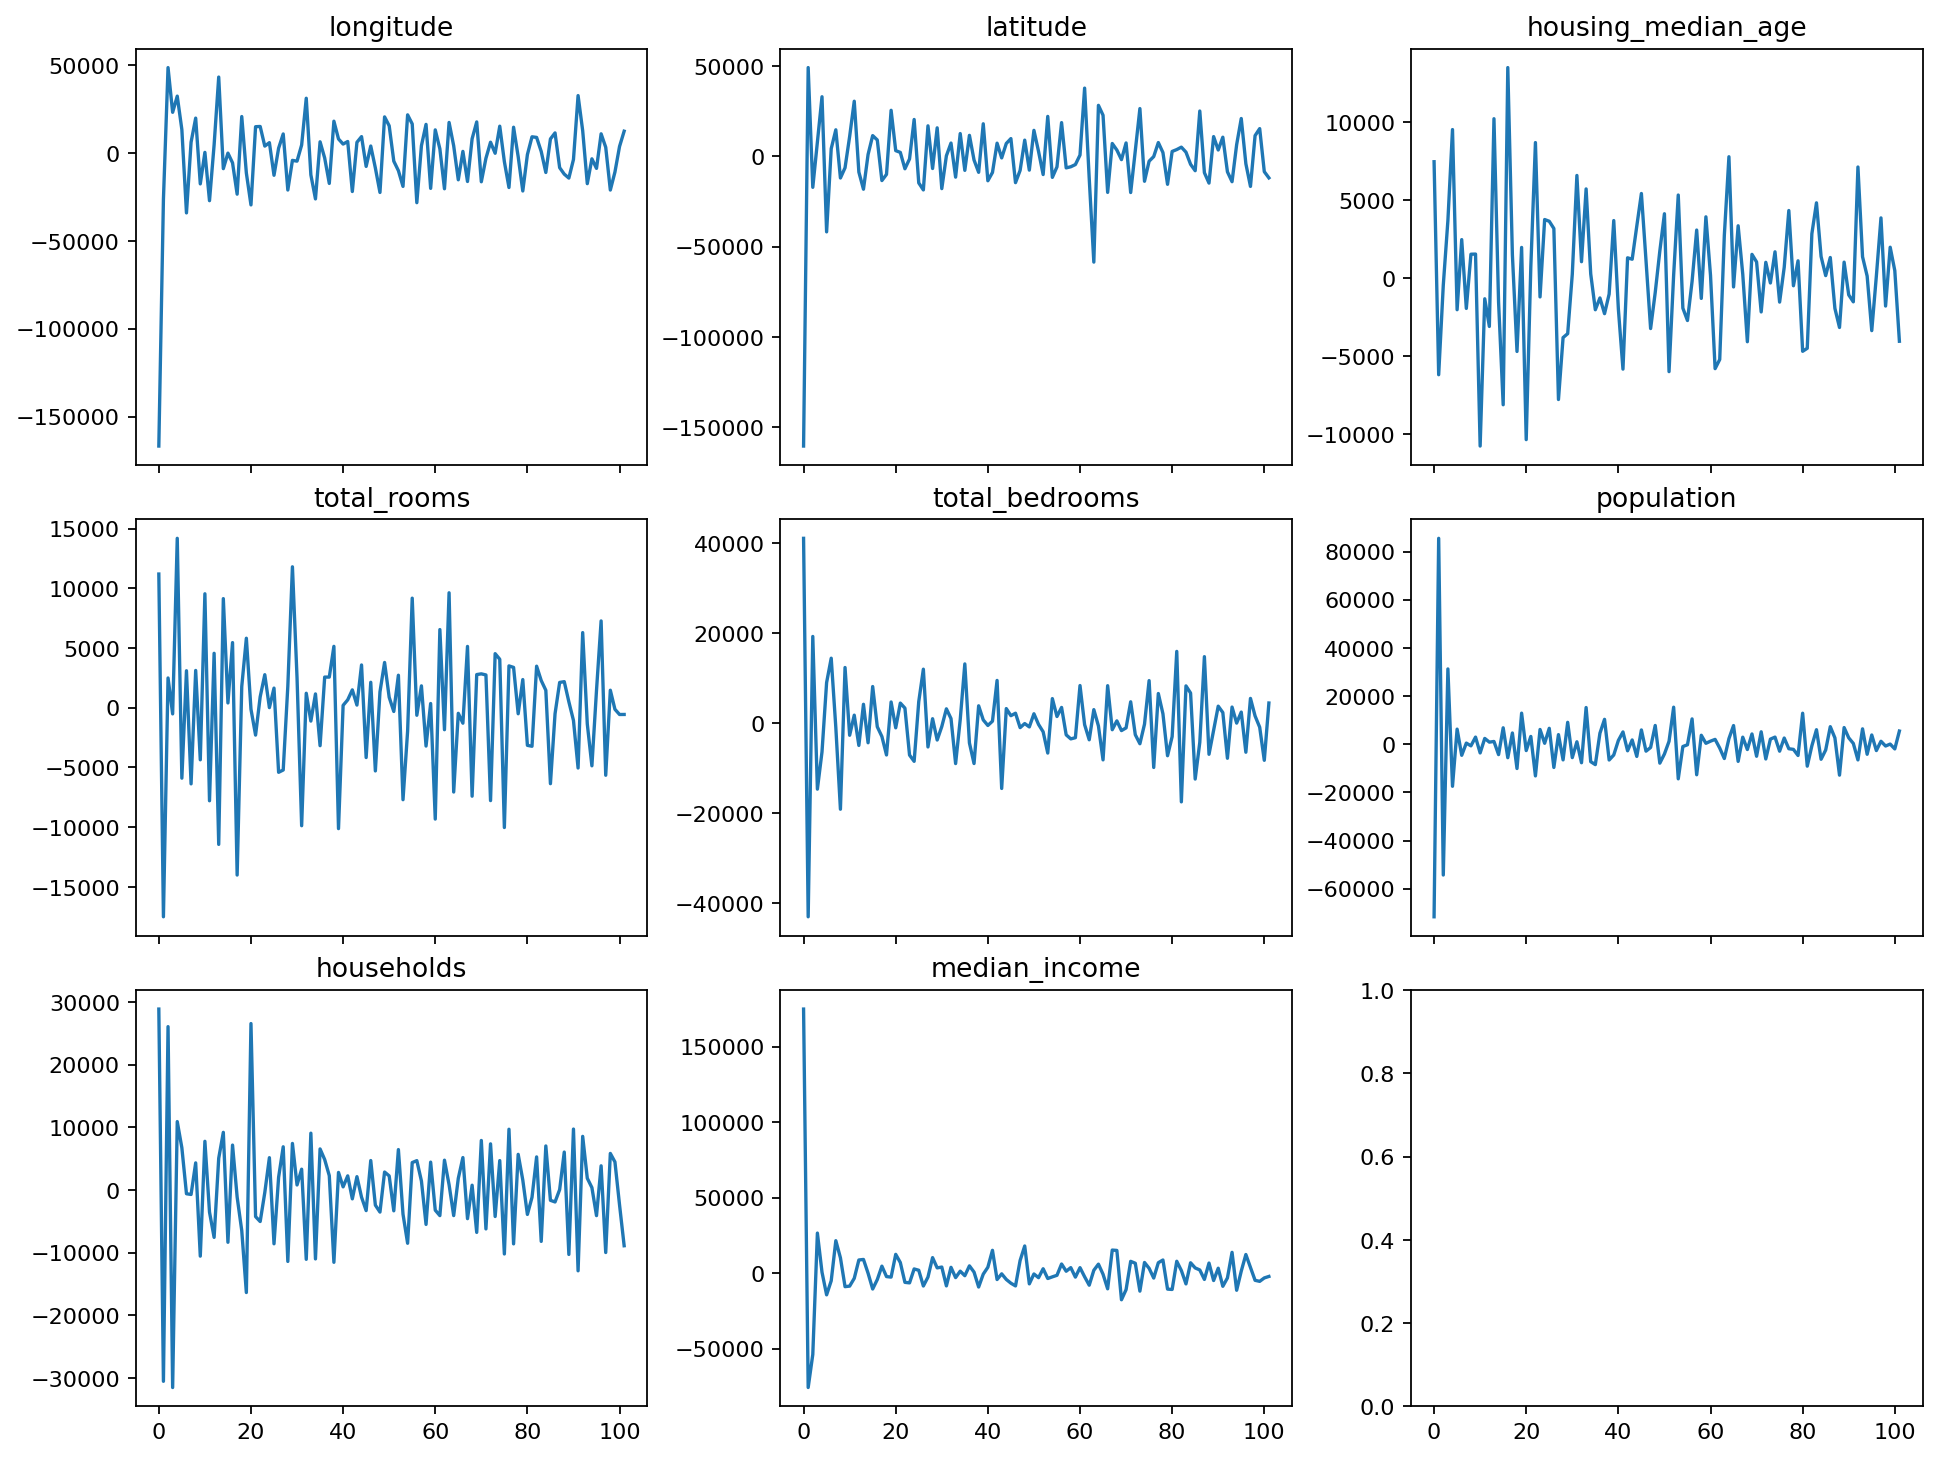

In [ ]:
plot_spectra(best_pipeline)

In [ ]:
degrees_to_try = range(0, best_degree)
pruned_pipeline = deepcopy(best_pipeline)

for feature in range(X_train.shape[1]):
    best_deg = 0
    best_error = np.inf
    for deg in degrees_to_try:
        candidate = prune_feature(pruned_pipeline, feature, deg)
        pred = candidate.predict(X_valid)
        error = root_mean_squared_error(y_valid, pred)
        if error <= best_error:
            best_error = error
            best_deg = deg

    print(f"Best degree for feature {X_train.columns[feature]}: {best_deg}, validation error: {best_error}")
    pruned_pipeline = prune_feature(pruned_pipeline, feature, best_deg)

Best degree for feature longitude: 100, validation error: 57886.75083218771
Best degree for feature latitude: 99, validation error: 57884.23600560439
Best degree for feature housing_median_age: 77, validation error: 57832.46845479303
Best degree for feature total_rooms: 1, validation error: 57258.77663424223
Best degree for feature total_bedrooms: 13, validation error: 56978.72710952217
Best degree for feature population: 27, validation error: 56673.91509748052
Best degree for feature households: 27, validation error: 56453.035725897564
Best degree for feature median_income: 8, validation error: 56142.80647476099


In [ ]:
test_error = root_mean_squared_error(y_test, pruned_pipeline.predict(X_test))
print(f'Test error = {test_error:.4f}')

Test error = 58598.2801
